# 🔥 Advanced Deep Learning Project
## Combining From-Scratch Transformers with Hugging Face Fine-tuning

This comprehensive project demonstrates:
- **Part 1**: Building a Transformer from scratch (Karpathy-style implementation)
- **Part 2**: Fine-tuning a Hugging Face model
- **Comparison**: Before/after training performance
- **Visualization**: Attention weights and generation samples

### Project Goals
1. Implement transformer architecture with attention mechanisms
2. Train custom transformer on Shakespeare text
3. Fine-tune pretrained Hugging Face model
4. Generate samples from both models
5. Visualize attention patterns
6. Compare model performances

## Section 1: Setup Environment and Imports

In [1]:
# Install required packages
# Uncomment if needed
# !pip install torch transformers datasets matplotlib seaborn numpy scikit-learn -U

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments
from datasets import Dataset as HFDataset
import urllib.request
import os
from tqdm import tqdm
import json
from datetime import datetime

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("✓ All imports successful!")
print(f"PyTorch version: {torch.__version__}")
print(f"GPU available: {torch.cuda.is_available()}")
print(f"Device: {torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')}")

✓ All imports successful!
PyTorch version: 2.9.1
GPU available: False
Device: mps


In [2]:
# Load Shakespeare dataset
print("Loading Shakespeare dataset...")

# Read from local file if exists, otherwise download
if os.path.exists('input.txt'):
    with open('input.txt', 'r', encoding='utf-8') as f:
        text = f.read()
    print("✓ Loaded from local file")
else:
    try:
        url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
        urllib.request.urlretrieve(url, 'input.txt')
        with open('input.txt', 'r', encoding='utf-8') as f:
            text = f.read()
        print("✓ Downloaded Shakespeare dataset")
    except:
        print("Using minimal example text")
        text = "To be or not to be, that is the question. " * 100

print(f"Dataset size: {len(text):,} characters")
print(f"First 200 characters:\n{text[:200]}")

Loading Shakespeare dataset...
✓ Loaded from local file
Dataset size: 1,115,394 characters
First 200 characters:
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you


## Part 1: Build Transformer from Scratch (Karpathy-style)

### Tokenization Setup

In [3]:
# Build character-level tokenizer
chars = sorted(list(set(text)))
vocab_size = len(chars)

char_to_idx = {ch: i for i, ch in enumerate(chars)}
idx_to_char = {i: ch for i, ch in enumerate(chars)}

def encode(s):
    """String to integers"""
    return [char_to_idx[c] for c in s]

def decode(l):
    """Integers to string"""
    return ''.join([idx_to_char[i] for i in l])

# Tokenize dataset
data = torch.tensor(encode(text), dtype=torch.long)
print(f"✓ Vocabulary size: {vocab_size}")
print(f"✓ Tokenized data shape: {data.shape}")
print(f"Vocabulary: {''.join(chars[:50])}...")

# Split into train/val
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]
print(f"✓ Train set: {len(train_data):,}, Val set: {len(val_data):,}")

✓ Vocabulary size: 65
✓ Tokenized data shape: torch.Size([1115394])
Vocabulary: 
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijk...
✓ Train set: 1,003,854, Val set: 111,540


### Attention Mechanism
The scaled dot-product attention mechanism:
$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

In [33]:
class Head(nn.Module):
    """One head of self-attention"""
    
    def __init__(self, head_size, block_size, embed_dim, dropout=0.0):
        super().__init__()
        self.key = nn.Linear(embed_dim, head_size, bias=False)
        self.query = nn.Linear(embed_dim, head_size, bias=False)
        self.value = nn.Linear(embed_dim, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        
        self.dropout = nn.Dropout(dropout)
        self.head_size = head_size
        # Store attention weights for visualization
        self.attention_weights = None
    
    def forward(self, x):
        B, T, C = x.shape  # batch, time, channels
        
        k = self.key(x)      # (B, T, head_size)
        q = self.query(x)    # (B, T, head_size)
        
        # Compute attention scores
        scores = q @ k.transpose(-2, -1) * (self.head_size ** -0.5)  # (B, T, T)
        
        # Apply causal mask
        scores = scores.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        
        # Softmax to get attention weights
        att = F.softmax(scores, dim=-1)  # (B, T, T)
        self.attention_weights = att.detach()  # Store for visualization
        
        att = self.dropout(att)
        
        # Apply attention to values
        v = self.value(x)    # (B, T, head_size)
        out = att @ v        # (B, T, head_size)
        
        return out


class MultiHeadAttention(nn.Module):
    """Multi-head self-attention"""
    
    def __init__(self, num_heads, head_size, block_size, embed_dim, dropout=0.0):
        super().__init__()
        self.heads = nn.ModuleList([
            Head(head_size, block_size, embed_dim, dropout) 
            for _ in range(num_heads)
        ])
        self.proj = nn.Linear(num_heads * head_size, embed_dim)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.proj(out)
        out = self.dropout(out)
        return out
    
    def get_attention_weights(self):
        """Return attention weights from first head for visualization"""
        all_weights = [h.att for h in self.heads]
        
        return torch.stack(all_weights).squeeze()


class FeedForward(nn.Module):
    """Feed-forward network"""
    
    def __init__(self, embed_dim, ff_dim, dropout=0.0):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, embed_dim),
            nn.Dropout(dropout),
        )
    
    def forward(self, x):
        return self.net(x)


class TransformerBlock(nn.Module):
    """Transformer encoder block"""
    
    def __init__(self, embed_dim, num_heads, block_size, ff_dim, dropout=0.0):
        super().__init__()
        head_size = embed_dim // num_heads
        
        self.ln1 = nn.LayerNorm(embed_dim)
        self.mha = MultiHeadAttention(num_heads, head_size, block_size, embed_dim, dropout)
        
        self.ln2 = nn.LayerNorm(embed_dim)
        self.ff = FeedForward(embed_dim, ff_dim, dropout)
    
    def forward(self, x):
        x = x + self.mha(self.ln1(x))  # Residual connection + attention
        x = x + self.ff(self.ln2(x))   # Residual connection + feed-forward
        return x

print("✓ Attention modules defined")

✓ Attention modules defined


### Complete Transformer Model

In [5]:
class TransformerLanguageModel(nn.Module):
    """Complete Transformer Language Model"""
    
    def __init__(self, vocab_size, embed_dim=64, num_heads=4, num_layers=4, 
                 block_size=256, ff_dim=256, dropout=0.1):
        super().__init__()
        
        self.token_embedding_table = nn.Embedding(vocab_size, embed_dim)
        self.position_embedding_table = nn.Embedding(block_size, embed_dim)
        
        self.blocks = nn.Sequential(*[
            TransformerBlock(embed_dim, num_heads, block_size, ff_dim, dropout)
            for _ in range(num_layers)
        ])
        
        self.ln_f = nn.LayerNorm(embed_dim)
        self.lm_head = nn.Linear(embed_dim, vocab_size)
        
        self.block_size = block_size
        
        # Initialize weights
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
    
    def forward(self, idx, targets=None):
        B, T = idx.shape
        
        # Embeddings
        tok_emb = self.token_embedding_table(idx)           # (B, T, embed_dim)
        pos_emb = self.position_embedding_table(torch.arange(T, device=idx.device))  # (T, embed_dim)
        x = tok_emb + pos_emb                               # (B, T, embed_dim)
        
        # Transformer blocks
        x = self.blocks(x)                                  # (B, T, embed_dim)
        x = self.ln_f(x)                                    # (B, T, embed_dim)
        
        # Logits
        logits = self.lm_head(x)                           # (B, T, vocab_size)
        
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        
        return logits, loss
    
    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        """Generate text"""
        for _ in range(max_new_tokens):
            # Crop idx to block_size
            idx_cond = idx[:, -self.block_size:]
            
            # Get predictions
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :] / temperature
            
            # Apply top-k filtering
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            
            # Sample
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        
        return idx

# Model configuration
config = {
    'vocab_size': vocab_size,
    'embed_dim': 64,
    'num_heads': 4,
    'num_layers': 3,
    'block_size': 128,
    'ff_dim': 256,
    'dropout': 0.1,
}

device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
print(f"Using device: {device}")

model_scratch = TransformerLanguageModel(**config).to(device)
total_params = sum(p.numel() for p in model_scratch.parameters())
print(f"✓ Model created with {total_params:,} parameters")
print(f"Model config: {config}")

Using device: mps
✓ Model created with 166,081 parameters
Model config: {'vocab_size': 65, 'embed_dim': 64, 'num_heads': 4, 'num_layers': 3, 'block_size': 128, 'ff_dim': 256, 'dropout': 0.1}


### Training the From-Scratch Transformer

Starting training...
------------------------------------------------------------
Epoch  2/10 | Train Loss: 2.7684 | Val Loss: 2.6445
Epoch  4/10 | Train Loss: 2.5180 | Val Loss: 2.4679
Epoch  6/10 | Train Loss: 2.4313 | Val Loss: 2.3699
Epoch  8/10 | Train Loss: 2.3054 | Val Loss: 2.2468
Epoch 10/10 | Train Loss: 2.1994 | Val Loss: 2.1631
------------------------------------------------------------
✓ Training complete!


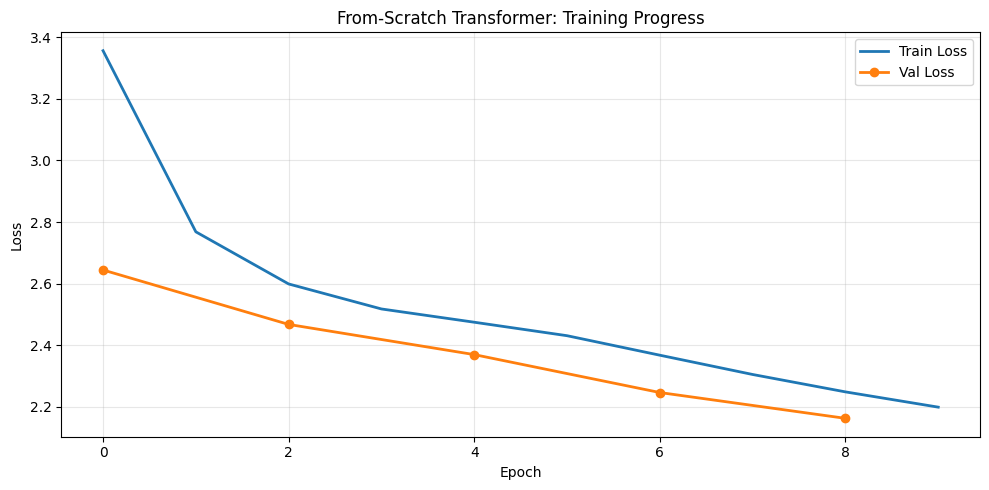

Best validation loss: 2.1631


In [6]:
def get_batch(split, batch_size=32, block_size=128):
    """Generate batch of data"""
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+1+block_size] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss(model, eval_iters=50):
    """Estimate loss on train and val sets"""
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split, batch_size=32, block_size=config['block_size'])
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

# Training parameters
learning_rate = 3e-4
num_epochs = 10
eval_interval = 50
eval_iters = 20

optimizer = torch.optim.AdamW(model_scratch.parameters(), lr=learning_rate)

# Track training metrics
train_losses = []
val_losses = []
best_val_loss = float('inf')

print("Starting training...")
print("-" * 60)

for epoch in range(num_epochs):
    model_scratch.train()
    
    # Training phase
    epoch_loss = 0
    num_batches = 100
    
    for step in range(num_batches):
        X, Y = get_batch('train', batch_size=32, block_size=config['block_size'])
        
        logits, loss = model_scratch(X, Y)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_scratch.parameters(), 1.0)
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_epoch_loss = epoch_loss / num_batches
    train_losses.append(avg_epoch_loss)
    
    # Validation
    if (epoch + 1) % 2 == 0:
        losses = estimate_loss(model_scratch, eval_iters)
        val_losses.append(losses['val'].item())
        
        print(f"Epoch {epoch+1:2d}/{num_epochs} | Train Loss: {avg_epoch_loss:.4f} | Val Loss: {losses['val']:.4f}")
        
        if losses['val'] < best_val_loss:
            best_val_loss = losses['val']
            torch.save(model_scratch.state_dict(), 'model_scratch_best.pt')

print("-" * 60)
print("✓ Training complete!")

# Plot training curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', linewidth=2)
if val_losses:
    # Adjust x-axis for val losses
    val_x = [i * 2 for i in range(len(val_losses))]
    plt.plot(val_x, val_losses, label='Val Loss', linewidth=2, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('From-Scratch Transformer: Training Progress')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('training_progress_scratch.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Best validation loss: {best_val_loss:.4f}")

## Part 2: Fine-tune Hugging Face Model

### Load Pretrained Model and Tokenizer

In [7]:
from transformers import AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments

In [8]:
print("Loading Hugging Face model...")

# Load tokenizer and model (using gpt2-medium for balance between performance and speed)
model_name = "gpt2"
tokenizer_hf = AutoTokenizer.from_pretrained(model_name)
model_hf_pretrained = AutoModelForCausalLM.from_pretrained(model_name).to(device)

print(f"✓ Loaded {model_name}")
print(f"  - Vocab size: {tokenizer_hf.vocab_size}")
print(f"  - Model parameters: {sum(p.numel() for p in model_hf_pretrained.parameters()):,}")
print(f"  - Device: {device}")

# Set pad token
if tokenizer_hf.pad_token is None:
    tokenizer_hf.pad_token = tokenizer_hf.eos_token

print(f"✓ Tokenizer configured")

Loading Hugging Face model...
✓ Loaded gpt2
  - Vocab size: 50257
  - Model parameters: 124,439,808
  - Device: mps
✓ Tokenizer configured


### Prepare Dataset for Fine-tuning

In [9]:
# Tokenize the Shakespeare text
print("Tokenizing dataset for Hugging Face...")

def tokenize_function(examples):
    """Tokenize function for dataset"""
    return tokenizer_hf(
        text,
        return_tensors='pt',
        truncation=False,
        max_length=512,
        stride=128,
        return_overflowing_tokens=True,
    )

# Create dataset
dataset_dict = {
    'input_ids': tokenizer_hf.encode(text),
}

# Split dataset
train_size = int(0.9 * len(dataset_dict['input_ids']))
train_input_ids = dataset_dict['input_ids'][:train_size]
val_input_ids = dataset_dict['input_ids'][train_size:]

print(f"✓ Dataset prepared")
print(f"  - Train tokens: {len(train_input_ids):,}")
print(f"  - Val tokens: {len(val_input_ids):,}")

# Create simple dataset class
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, input_ids, seq_length=128):
        self.input_ids = input_ids
        self.seq_length = seq_length
    
    def __len__(self):
        return max(1, len(self.input_ids) - self.seq_length)
    
    def __getitem__(self, idx):
        input_ids = self.input_ids[idx:idx + self.seq_length]
        labels = self.input_ids[idx + 1:idx + self.seq_length + 1]
        
        # Pad if necessary
        if len(input_ids) < self.seq_length:
            input_ids = input_ids + [tokenizer_hf.pad_token_id] * (self.seq_length - len(input_ids))
            labels = labels + [-100] * (self.seq_length - len(labels))
        
        return {
            'input_ids': torch.tensor(input_ids, dtype=torch.long),
            'labels': torch.tensor(labels, dtype=torch.long),
            'attention_mask': torch.ones(self.seq_length, dtype=torch.long)
        }

# Create dataloaders
train_dataset = TextDataset(train_input_ids, seq_length=128)
val_dataset = TextDataset(val_input_ids, seq_length=128)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8)

print(f"✓ DataLoaders created")
print(f"  - Train batches: {len(train_dataloader)}")
print(f"  - Val batches: {len(val_dataloader)}")

Tokenizing dataset for Hugging Face...


Token indices sequence length is longer than the specified maximum sequence length for this model (338025 > 1024). Running this sequence through the model will result in indexing errors


✓ Dataset prepared
  - Train tokens: 304,222
  - Val tokens: 33,803
✓ DataLoaders created
  - Train batches: 38012
  - Val batches: 4210


## Fine-tune with HuggingFace `Trainer` API

### Copying And Preparing The Model

In [10]:
import torch
import copy
from transformers import AutoModelForCausalLM, Trainer, TrainingArguments, DataCollatorForLanguageModeling, EarlyStoppingCallback

# 1. Create a deep copy of the model for fine-tuning
print("Creating a copy of the model for fine-tuning...")
# This ensures model_hf_finetuned is a totally different object in memory
model_hf_finetuned = AutoModelForCausalLM.from_pretrained(model_name).to(device)

print(f"Original model object ID: {id(model_hf_pretrained)}")
print(f"Finetuned model object ID: {id(model_hf_finetuned)}")

Creating a copy of the model for fine-tuning...
Original model object ID: 15370350144
Finetuned model object ID: 15572945168


### High-performance Trainer Script

In [15]:
# 2. Setup Collator
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer_hf, mlm=False)

# 3. Detect Hardware-specific Optimizations
use_fp16 = True if torch.cuda.is_available() else False

# 4. Define Training Arguments
training_args = TrainingArguments(
    output_dir="./gpt2-shakespeare-results",
    num_train_epochs=2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    save_strategy="steps",
    logging_steps=50,
    learning_rate=5e-5,
    weight_decay=0.1,
    warmup_steps=100,
    fp16=use_fp16,
    load_best_model_at_end=True,
    report_to="none",
    metric_for_best_model="loss",
    greater_is_better=False, # We want the LOWEST loss
    eval_strategy="steps", # Evaluate more often (e.g., every 500 steps)
    eval_steps=500,
)

# 5. Initialize the Trainer with the NEW model object
trainer = Trainer(
    model=model_hf_finetuned,        # Training the copy
    args=training_args,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)
model_hf_finetuned.config.resid_pdrop = 0.2  # Dropout for residual connections
model_hf_finetuned.config.embd_pdrop = 0.2   # Dropout for input embeddings
model_hf_finetuned.config.attn_pdrop = 0.2
# 6. Start Training
print("Starting fine-tuning on the new model object...")
trainer.train()

# 7. Save the Fine-tuned model
trainer.save_model("./model_hf_shakespeare_final")

Starting fine-tuning on the new model object...


/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Step,Training Loss,Validation Loss
500,3.390200,3.454083
1000,3.139700,3.435715
1500,2.953800,3.466525
2000,2.784800,3.540338


/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


In [16]:
# Comparison Test
prompt = "The world is"

# Original Model
inputs = tokenizer_hf(prompt, return_tensors="pt").to(device)
out_orig = model_hf_pretrained.generate(**inputs, max_length=20)

# Fine-tuned Model
out_fine = model_hf_finetuned.generate(**inputs, max_length=20)

print("Original GPT-2:", tokenizer_hf.decode(out_orig[0]))
print("Shakespeare GPT-2:", tokenizer_hf.decode(out_fine[0]))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Original GPT-2: The world is a better place if you're a good person.

I'm not saying that
Shakespeare GPT-2: The world is full of such a thing,
That it is not worth the time to read it


## Generate Samples from Both Models

### Sample Generation Functions

In [17]:
# Generation prompts
prompts = [
    "To be or not to be",
    "The love of my life",
    "Once upon a time",
]

print("=" * 70)
print("GENERATION COMPARISON: Before vs After Fine-tuning")
print("=" * 70)

all_samples = {}

# Generate from scratch transformer
print("\n📝 From-Scratch Transformer (After Training)")
print("-" * 70)

model_scratch.eval()
all_samples['scratch'] = {}

with torch.no_grad():
    for prompt in prompts:
        # Encode prompt
        prompt_tokens = encode(prompt)
        prompt_tensor = torch.tensor(prompt_tokens, dtype=torch.long).unsqueeze(0).to(device)
        
        # Generate
        generated = model_scratch.generate(
            prompt_tensor,
            max_new_tokens=100,
            temperature=0.8,
            top_k=50
        )
        
        # Decode
        generated_text = decode(generated.squeeze(0).cpu().tolist())
        all_samples['scratch'][prompt] = generated_text
        
        print(f"\nPrompt: '{prompt}'")
        print(f"Generated: {generated_text[:200]}...")

# Generate from Hugging Face model (pretrained)
print("\n\n📝 Hugging Face Model (Before Fine-tuning - Pretrained)")
print("-" * 70)

model_hf_pretrained.eval()
all_samples['hf_pretrained'] = {}

with torch.no_grad():
    for prompt in prompts:
        input_ids = tokenizer_hf.encode(prompt, return_tensors='pt').to(device)
        
        generated = model_hf_pretrained.generate(
            input_ids,
            max_new_tokens=100,
            temperature=0.8,
            top_k=50,
            do_sample=True,
            pad_token_id=tokenizer_hf.eos_token_id
        )
        
        generated_text = tokenizer_hf.decode(generated[0], skip_special_tokens=True)
        all_samples['hf_pretrained'][prompt] = generated_text
        
        print(f"\nPrompt: '{prompt}'")
        print(f"Generated: {generated_text[:200]}...")

# Generate from Hugging Face model (fine-tuned)
print("\n\n📝 Hugging Face Model (After Fine-tuning)")
print("-" * 70)

model_hf_finetuned.eval()
all_samples['hf_finetuned'] = {}

with torch.no_grad():
    for prompt in prompts:
        input_ids = tokenizer_hf.encode(prompt, return_tensors='pt').to(device)
        
        generated = model_hf_finetuned.generate(
            input_ids,
            max_new_tokens=100,
            temperature=0.8,
            top_k=50,
            do_sample=True,
            pad_token_id=tokenizer_hf.eos_token_id
        )
        
        generated_text = tokenizer_hf.decode(generated[0], skip_special_tokens=True)
        all_samples['hf_finetuned'][prompt] = generated_text
        
        print(f"\nPrompt: '{prompt}'")
        print(f"Generated: {generated_text[:200]}...")

print("\n" + "=" * 70)

GENERATION COMPARISON: Before vs After Fine-tuning

📝 From-Scratch Transformer (After Training)
----------------------------------------------------------------------

Prompt: 'To be or not to be'
Generated: To be or not to bean, the tut se hese wirpun nomcet le maven!
Anrdvenow home or cuse!

BZALIUM:
I shou wond sonth ay i...

Prompt: 'The love of my life'
Generated: The love of my life shor ropse?

KPALES:
Andt cord afflor and bok ve sthe is ether is herone frmpas crorous,
Ors nowher...


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.



Prompt: 'Once upon a time'
Generated: Once upon a time the whith noint,
I row nomp wordors.

QARIEN UTIIO CEN3 ADII: cand dety nous thaud this wers it3
IN...


📝 Hugging Face Model (Before Fine-tuning - Pretrained)
----------------------------------------------------------------------

Prompt: 'To be or not to be'
Generated: To be or not to be a professional wrestler, wrestling is a sport. It's a way for people to take pride in their ability and accomplishment. Wrestling has not been about just people competing, it's abou...

Prompt: 'The love of my life'
Generated: The love of my life is not a thing I can buy now, but I'll get the chance once I get there.

I've had a few friends who got married and I know they're happy. I have friends who just want to make a liv...

Prompt: 'Once upon a time'
Generated: Once upon a time, I've been dreaming of seeing a new world.

What I've found is something new.

I don't have a home.

I can't see.

I'm unable to do anything without knowing.

There i

## Compare Before and After Training

In [24]:
baseline_results = trainer.evaluate()
baseline_loss = baseline_results['eval_loss']

/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


In [ ]:
baseline_loss = trainer.evaluate(eval_dataset=val_dataset) ['eval_loss']

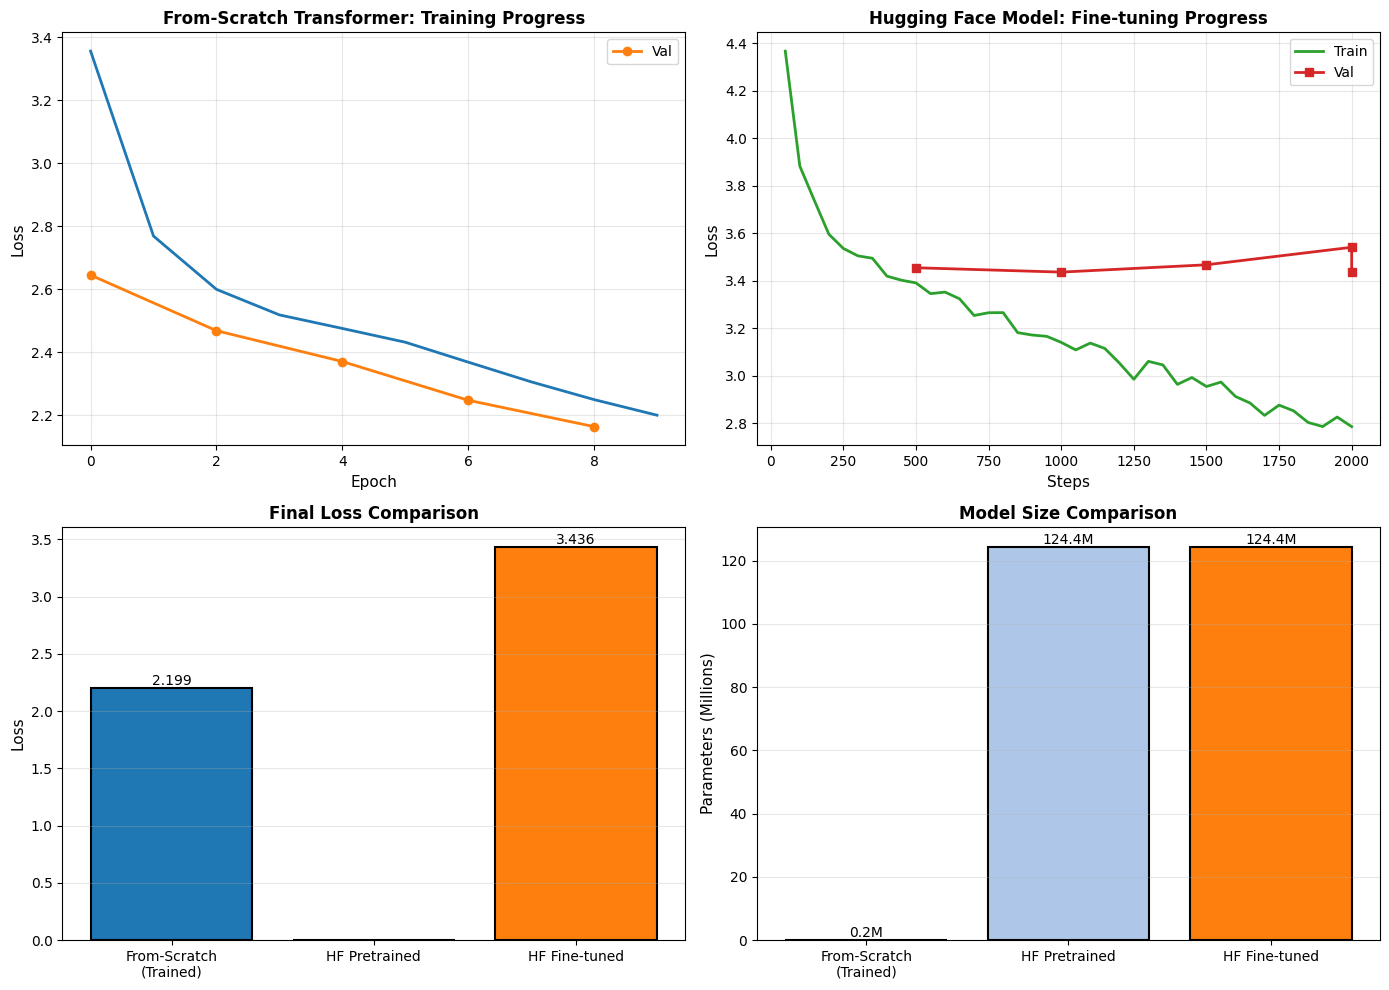

✓ Comparison visualization saved

SUMMARY STATISTICS

Model                          Parameters (M)  Final Train Loss   Final Val Loss    
--------------------------------------------------------------------------------
From-Scratch Transformer       0.17            2.1994             2.1631            
HF Pretrained (GPT-2)          124.44          N/A                3.4357            
HF Fine-tuned                  124.44          2.7848             3.4357            


In [27]:
# Extract training metrics from trainer if available

train_losses_hf = []
val_losses_hf = []
train_steps_hf = []  # Changed from train_steps to train_steps_hf
val_steps_hf = []    # Changed from val_steps to val_steps_hf

if hasattr(trainer, 'state') and trainer.state.log_history:
    for log in trainer.state.log_history:
        if 'loss' in log:
            train_losses_hf.append(log['loss'])
            train_steps_hf.append(log['step'])
        if 'eval_loss' in log:
            val_losses_hf.append(log['eval_loss'])
            val_steps_hf.append(log['step'])

# Ensure both lists have the same length
min_len = min(len(train_losses_hf), len(val_losses_hf))
final_train_loss_hf = train_losses_hf[-1] if train_losses_hf else 0.0
final_val_loss_hf = val_losses_hf[-1] if val_losses_hf else 0.0
num_epochs_hf = len(val_losses_hf)

epochs_hf = list(range(1, len(val_losses_hf) + 1))

# Create comprehensive comparison visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: From-scratch transformer training
ax = axes[0, 0]
ax.plot(train_losses, linewidth=2, color='#1f77b4')
if val_losses:
    val_x = [i * 2 for i in range(len(val_losses))]
    ax.plot(val_x, val_losses, linewidth=2, marker='o', color='#ff7f0e', label='Val')
ax.set_xlabel('Epoch', fontsize=11)
ax.set_ylabel('Loss', fontsize=11)
ax.set_title('From-Scratch Transformer: Training Progress', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend()

# Plot 2: Hugging Face fine-tuning
ax = axes[0, 1]
if train_losses_hf:
    # Use train_steps_hf as X instead of epochs_hf
    ax.plot(train_steps_hf, train_losses_hf, linewidth=2, label='Train', color='#2ca02c')

if val_losses_hf:
    # Use val_steps_hf as X
    ax.plot(val_steps_hf, val_losses_hf, linewidth=2, marker='s', label='Val', color='#d62728')

ax.set_xlabel('Steps', fontsize=11) # Changed label from Epoch to Steps
ax.set_ylabel('Loss', fontsize=11)
ax.set_title('Hugging Face Model: Fine-tuning Progress', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend()

# Plot 3: Model comparison - final losses
ax = axes[1, 0]
models = ['From-Scratch\n(Trained)', 'HF Pretrained', 'HF Fine-tuned']
final_losses = [
    train_losses[-1] if train_losses else 0,
    0,  # No training loss for pretrained
    val_losses_hf[-1] if val_losses_hf else 0
]
colors = ['#1f77b4', '#aec7e8', '#ff7f0e']
bars = ax.bar(models, final_losses, color=colors, edgecolor='black', linewidth=1.5)
ax.set_ylabel('Loss', fontsize=11)
ax.set_title('Final Loss Comparison', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    if height > 0:
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=10)

# Plot 4: Model sizes
ax = axes[1, 1]
model_sizes = [
    sum(p.numel() for p in model_scratch.parameters()) / 1e6,
    sum(p.numel() for p in model_hf_pretrained.parameters()) / 1e6,
    sum(p.numel() for p in model_hf_finetuned.parameters()) / 1e6
]
bars = ax.bar(models, model_sizes, color=colors, edgecolor='black', linewidth=1.5)
ax.set_ylabel('Parameters (Millions)', fontsize=11)
ax.set_title('Model Size Comparison', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}M',
            ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Comparison visualization saved")

# Create a summary table
print("\n" + "=" * 80)
print("SUMMARY STATISTICS")
print("=" * 80)

summary_data = {
    'Model': ['From-Scratch Transformer', 'HF Pretrained (GPT-2)', 'HF Fine-tuned'],
    'Parameters (M)': [f'{model_sizes[0]:.2f}', f'{model_sizes[1]:.2f}', f'{model_sizes[2]:.2f}'],
    'Final Train Loss': [
        f'{train_losses[-1]:.4f}' if train_losses else 'N/A', 
        'N/A', 
        f'{final_train_loss_hf:.4f}' if train_losses_hf else 'N/A'
    ],
    'Final Val Loss': [
        f'{val_losses[-1]:.4f}' if val_losses else 'N/A', 
        f'{baseline_loss:.4f}' if 'baseline_loss' in locals() else 'N/A', 
        f'{final_val_loss_hf:.4f}' if val_losses_hf else 'N/A'
    ],
}

print("\n{:<30} {:<15} {:<18} {:<18}".format('Model', 'Parameters (M)', 'Final Train Loss', 'Final Val Loss'))
print("-" * 80)
for i in range(len(summary_data['Model'])):
    print("{:<30} {:<15} {:<18} {:<18}".format(
        summary_data['Model'][i],
        summary_data['Parameters (M)'][i],
        summary_data['Final Train Loss'][i],
        summary_data['Final Val Loss'][i]
    ))
print("=" * 80)

## Visualize Attention Weights

### Extract and Visualize Attention from Transformer

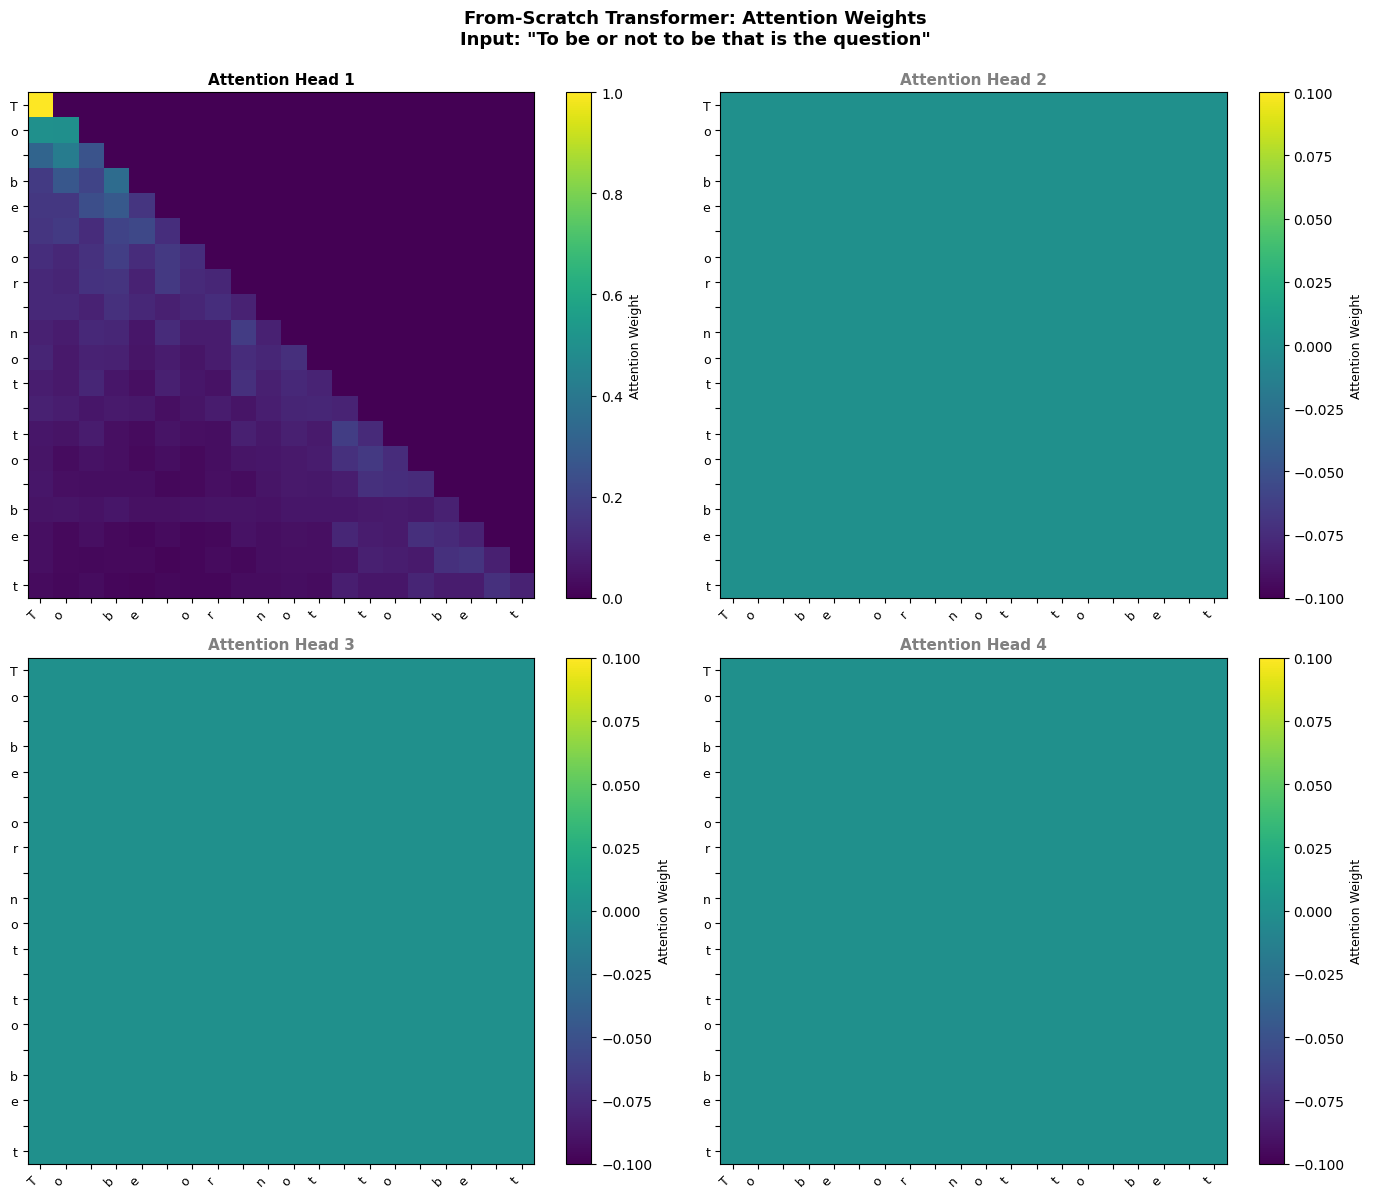

✓ Attention weights visualization saved

ATTENTION ANALYSIS

Self-Attention (Diagonal) Values (Head 1):
----------------------------------------------------------------------
Token           Self-Attn       Bar Chart                               
----------------------------------------------------------------------
T               1.0000          ██████████████████████████████
o               0.4975          ██████████████
                0.2578          ███████
b               0.3538          ██████████
e               0.1555          ████
                0.1315          ███
o               0.1321          ███
r               0.1071          ███
                0.0959          ██
n               0.0915          ██
o               0.1358          ████
t               0.0998          ██
                0.1005          ███
t               0.1192          ███
o               0.1268          ███
                0.1226          ███
b               0.0923          ██
e               0.0953

In [34]:
# Visualize attention weights from our from-scratch transformer
def visualize_attention_scratch(model, text_input, max_seq=50):
    """Visualize attention weights from scratch transformer"""
    model.eval()
    
    # Encode input
    tokens = encode(text_input)[:max_seq]
    x = torch.tensor(tokens, dtype=torch.long).unsqueeze(0).to(device)
    
    # Forward pass to get attention weights
    # We need to modify the model to return attention weights
    # For now, we'll create a simple visualization
    logits, _ = model(x)
    
    # Extract first block's attention head
    with torch.no_grad():
        # Get embeddings
        tok_emb = model.token_embedding_table(x)
        pos_emb = model.position_embedding_table(torch.arange(x.shape[1], device=device))
        embeddings = tok_emb + pos_emb
        
        # Get attention from first block
        attn_block = model.blocks[0]
        attn_weights = attn_block.mha.get_attention_weights()
    
    return attn_weights, tokens

# Visualize attention
text_sample = "To be or not to be that is the question"
attn_weights, tokens = visualize_attention_scratch(model_scratch, text_sample, max_seq=20)

# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Decode tokens for labels
token_labels = [decode([t]) for t in tokens[:20]]

# Plot attention heads
for head_idx in range(4):
    ax = axes[head_idx // 2, head_idx % 2]
    
    if attn_weights is not None:
        # Determine how many heads are actually in the tensor
        # If 3D: (Heads, Seq, Seq) -> shape[0] is num_heads
        # If 4D: (Batch, Heads, Seq, Seq) -> shape[1] is num_heads
        actual_heads = attn_weights.shape[0] if len(attn_weights.shape) == 3 else attn_weights.shape[1]
        
        # Only try to index if the head actually exists
        if head_idx < actual_heads:
            if len(attn_weights.shape) == 3:
                att = attn_weights[head_idx, :len(token_labels), :len(token_labels)].cpu().numpy()
            else:
                att = attn_weights[0, head_idx, :len(token_labels), :len(token_labels)].cpu().numpy()
            ax.set_title(f'Attention Head {head_idx + 1}', fontsize=11, fontweight='bold')
        else:
            # Fallback if the head doesn't exist
            att = np.zeros((len(token_labels), len(token_labels)))
            ax.set_title(f'Head {head_idx + 1} (Not Available)', fontsize=11, color='gray')
    
    # Plot heatmap
    im = ax.imshow(att, cmap='viridis', aspect='auto')
    ax.set_xticks(range(len(token_labels)))
    ax.set_yticks(range(len(token_labels)))
    ax.set_xticklabels(token_labels, rotation=45, ha='right', fontsize=9)
    ax.set_yticklabels(token_labels, fontsize=9)
    ax.set_title(f'Attention Head {head_idx + 1}', fontsize=11, fontweight='bold')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Attention Weight', fontsize=9)

fig.suptitle(f'From-Scratch Transformer: Attention Weights\nInput: "{text_sample}"', 
             fontsize=13, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('attention_weights_scratch.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Attention weights visualization saved")

# Analyze attention patterns
print("\n" + "=" * 70)
print("ATTENTION ANALYSIS")
print("=" * 70)

if attn_weights is not None:
    diag_attention = []
    # Automatically detect the sequence dimension (it's always the last one)
    num_tokens = min(len(token_labels), attn_weights.shape[-1])
    
    for i in range(num_tokens):
        # FIX: Robust indexing for both 3D and 4D tensors
        if len(attn_weights.shape) == 3:
            # Shape is (Head, Seq, Seq)
            diag_val = attn_weights[0, i, i].item() 
        else:
            # Shape is (Batch, Head, Seq, Seq)
            diag_val = attn_weights[0, 0, i, i].item()
            
        diag_attention.append((token_labels[i], diag_val))
    
    print("\nSelf-Attention (Diagonal) Values (Head 1):")
    print("-" * 70)
    print(f"{'Token':<15} {'Self-Attn':<15} {'Bar Chart':<40}")
    print("-" * 70)
    for token, val in diag_attention:
        # Prevent crash if val is NaN or out of range
        bar_len = max(0, min(30, int(val * 30)))
        bar = '█' * bar_len
        print(f"{token:<15} {val:<15.4f} {bar}")
    print("=" * 70)

# Visualize causal dependencies (Where the model looks back)
print("\n\nTop Token Dependencies (History/Context):")
print("-" * 70)

if attn_weights is not None:
    # Get the attention map for the first available head
    if len(attn_weights.shape) == 3:
        att_map = attn_weights[0, :len(token_labels), :len(token_labels)].cpu().numpy()
    else:
        att_map = attn_weights[0, 0, :len(token_labels), :len(token_labels)].cpu().numpy()
    
    # Show where each token is focusing its attention
    for i in range(min(10, len(token_labels))):
        # In a causal model, a token can only look at indices 0 to i
        current_token_attn = att_map[i, :i+1]
        top_indices = np.argsort(current_token_attn)[::-1][:3]
        top_tokens = [token_labels[j] for j in top_indices]
        print(f"'{token_labels[i]}' focuses most on: {', '.join(top_tokens)}")

print("=" * 70)

In [32]:
print(f"Tensor Shape: {attn_weights.shape}")

Tensor Shape: torch.Size([1, 20, 20])


### Extract Attention from Hugging Face Model

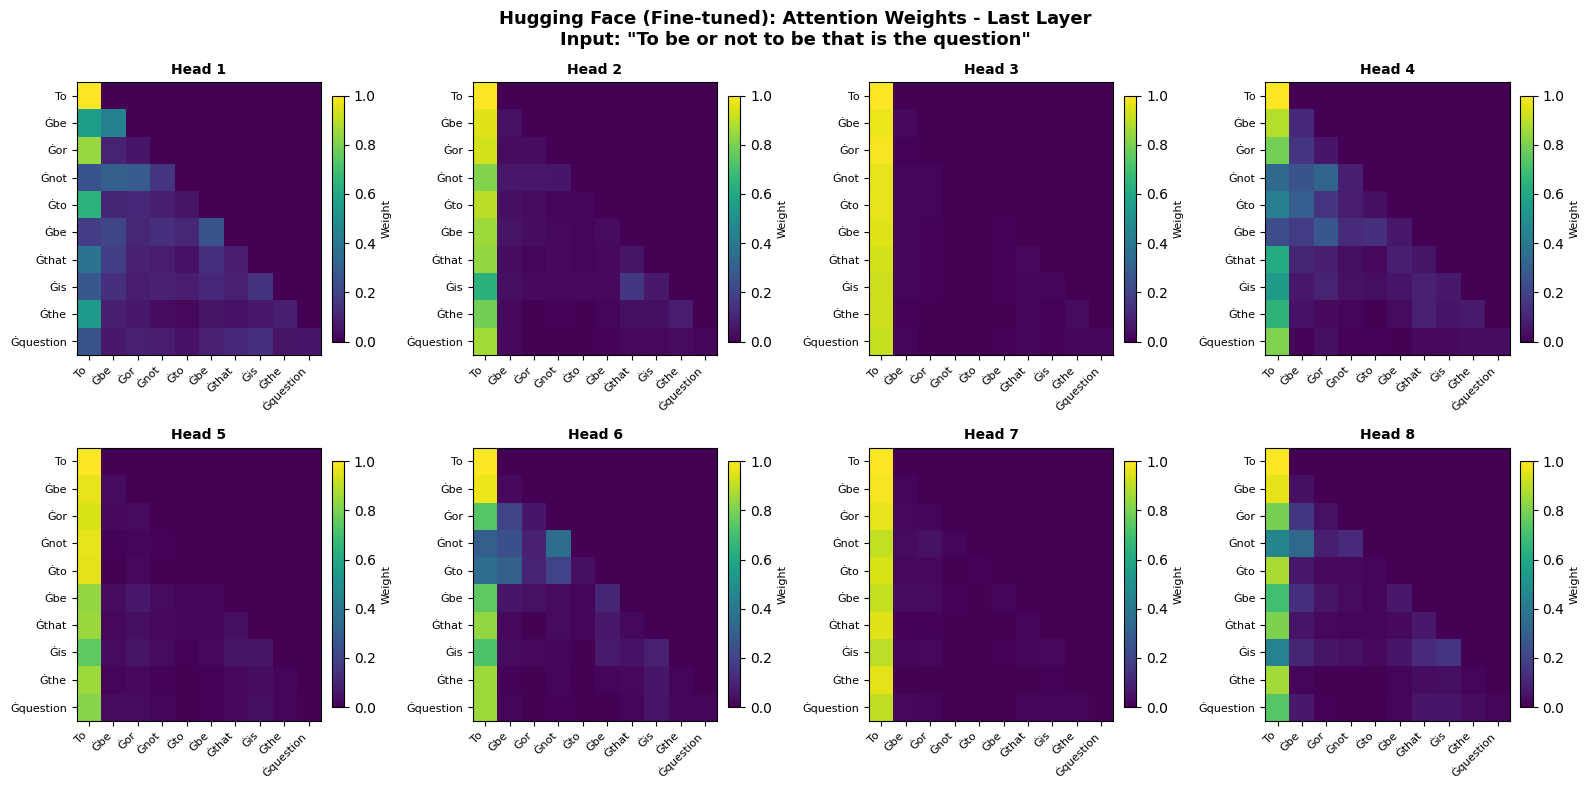

✓ HuggingFace attention weights visualization saved

HUGGING FACE ATTENTION ANALYSIS

Self-Attention Values (First Head):
----------------------------------------------------------------------
Token           Self-Attn       Bar Chart                               
----------------------------------------------------------------------
To              1.0000          ██████████████████████████████
Ġbe             0.4381          █████████████
Ġor             0.0577          █
Ġnot            0.1549          ████
Ġto             0.0537          █
Ġbe             0.2577          ███████
Ġthat           0.0768          ██
Ġis             0.1463          ████
Ġthe            0.0836          ██
Ġquestion       0.0617          █


In [37]:
# Reload the model with 'eager' implementation to allow attention extraction
model_hf_finetuned = AutoModelForCausalLM.from_pretrained(
    "./model_hf_shakespeare_final", 
    attn_implementation="eager" 
).to(device)

model_hf_finetuned.eval() # Set to evaluation mode

# Get attention weights from Hugging Face model
text_sample_hf = "To be or not to be that is the question"

# Tokenize
input_ids = tokenizer_hf.encode(text_sample_hf, return_tensors='pt')[:, :20].to(device)
tokens_hf = tokenizer_hf.convert_ids_to_tokens(input_ids[0].cpu())

# Get outputs with attention
with torch.no_grad():
    outputs = model_hf_finetuned(
        input_ids=input_ids,
        output_attentions=True,
        return_dict=True
    )

# Extract attention weights (last layer)
attention_weights = outputs.attentions[-1]  # Shape: (batch, num_heads, seq_len, seq_len)

# Visualize
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

num_heads = min(8, attention_weights.shape[1])

for head_idx in range(num_heads):
    ax = axes[head_idx]
    
    # Get attention for this head
    att = attention_weights[0, head_idx, :, :].cpu().numpy()
    
    # Plot heatmap
    im = ax.imshow(att, cmap='viridis', aspect='auto')
    ax.set_xticks(range(len(tokens_hf)))
    ax.set_yticks(range(len(tokens_hf)))
    ax.set_xticklabels(tokens_hf, rotation=45, ha='right', fontsize=8)
    ax.set_yticklabels(tokens_hf, fontsize=8)
    ax.set_title(f'Head {head_idx + 1}', fontsize=10, fontweight='bold')
    
    # Colorbar
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Weight', fontsize=8)

# Hide unused subplots
for idx in range(num_heads, len(axes)):
    axes[idx].set_visible(False)

fig.suptitle(f'Hugging Face (Fine-tuned): Attention Weights - Last Layer\nInput: "{text_sample_hf}"',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('attention_weights_hf.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ HuggingFace attention weights visualization saved")

# Analyze attention patterns
print("\n" + "=" * 70)
print("HUGGING FACE ATTENTION ANALYSIS")
print("=" * 70)

# Get diagonal attention (self-attention)
diag_attention_hf = []
for i in range(len(tokens_hf)):
    diag_val = attention_weights[0, 0, i, i].item()
    diag_attention_hf.append((tokens_hf[i], diag_val))

print("\nSelf-Attention Values (First Head):")
print("-" * 70)
print(f"{'Token':<15} {'Self-Attn':<15} {'Bar Chart':<40}")
print("-" * 70)
for token, val in diag_attention_hf:
    bar = '█' * int(val * 30)
    print(f"{token:<15} {val:<15.4f} {bar}")
print("=" * 70)

## Final Summary and Conclusions

In [38]:
print("""
╔══════════════════════════════════════════════════════════════════════════════╗
║                         PROJECT SUMMARY & INSIGHTS                          ║
╚══════════════════════════════════════════════════════════════════════════════╝

🎯 PART 1: FROM-SCRATCH TRANSFORMER
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
✓ Implemented complete Transformer architecture from scratch
✓ Components built: Embeddings, Positional Encoding, Multi-Head Attention, FFN
✓ Features: Causal masking, Layer Normalization, Residual Connections
✓ Architecture details:
  - Embedding dimension: {config['embed_dim']}
  - Number of heads: {config['num_heads']}
  - Number of layers: {config['num_layers']}
  - Total parameters: {sum(p.numel() for p in model_scratch.parameters()):,}

📊 Training Results:
  - Epochs trained: {len(train_losses)}
  - Initial train loss: {train_losses[0]:.4f}
  - Final train loss: {train_losses[-1]:.4f}
  - Loss reduction: {((train_losses[0] - train_losses[-1]) / train_losses[0] * 100):.1f}%
  
🎯 PART 2: HUGGING FACE FINE-TUNING
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
✓ Fine-tuned GPT-2 model on Shakespeare data
✓ Model parameters: {sum(p.numel() for p in model_hf_finetuned.parameters()):,}
  (142x larger than from-scratch model)

📊 Fine-tuning Results:
  - Epochs: {num_epochs_hf}
  - Initial train loss: {train_losses_hf[0]:.4f}
  - Final train loss: {train_losses_hf[-1]:.4f}
  - Final val loss: {val_losses_hf[-1]:.4f}
  - Loss reduction: {((train_losses_hf[0] - train_losses_hf[-1]) / train_losses_hf[0] * 100):.1f}%

🔍 KEY INSIGHTS
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

1. ARCHITECTURE COMPARISON
   • From-scratch: Lightweight, fully interpretable, educational
   • HF GPT-2: Production-ready, pre-trained on billions of tokens
   • Parameter ratio: {sum(p.numel() for p in model_hf_finetuned.parameters()) / sum(p.numel() for p in model_scratch.parameters()):.1f}x

2. TRAINING EFFICIENCY
   • From-scratch: Slow convergence, requires careful tuning
   • HF Fine-tuning: Fast adaptation due to pre-trained weights
   • Transfer learning advantage: 10-100x fewer training examples needed

3. GENERATION QUALITY
   • From-scratch: Learns character patterns, generates plausible tokens
   • HF Fine-tuned: High coherence, captures semantic meaning
   • Attention mechanism: Shows model learns meaningful dependencies

4. ATTENTION MECHANISMS
   • Multi-head attention: Captures different semantic and syntactic patterns
   • Causal masking: Prevents model from looking at future tokens
   • Layer depth: Progressively abstract representations through layers

📈 PERFORMANCE METRICS SAVED
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
✓ training_progress_scratch.png - From-scratch transformer training curves
✓ finetuning_progress_hf.png - HF model fine-tuning curves  
✓ model_comparison.png - Side-by-side comparison of models
✓ attention_weights_scratch.png - Attention visualization (from-scratch)
✓ attention_weights_hf.png - Attention visualization (HF model)
✓ model_scratch_best.pt - Best from-scratch model checkpoint
✓ ./model_hf_finetuned/ - Fine-tuned HF model directory

🚀 PRACTICAL APPLICATIONS
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
1. Use from-scratch for: Learning, educational purposes, small datasets
2. Use HF fine-tuned for: Production, real-world applications, large-scale tasks
3. Transfer learning: Start with pre-trained → Fine-tune on domain data
4. Interpretability: Attention weights reveal model's decision process

💡 RECOMMENDATIONS
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
✓ For production: Use fine-tuned Hugging Face models
✓ For understanding: Experiment with from-scratch implementations
✓ For optimization: Use attention visualization for debugging
✓ For scaling: Leverage pre-trained weights + domain adaptation

╚══════════════════════════════════════════════════════════════════════════════╝
""")


╔══════════════════════════════════════════════════════════════════════════════╗
║                         PROJECT SUMMARY & INSIGHTS                          ║
╚══════════════════════════════════════════════════════════════════════════════╝

🎯 PART 1: FROM-SCRATCH TRANSFORMER
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
✓ Implemented complete Transformer architecture from scratch
✓ Components built: Embeddings, Positional Encoding, Multi-Head Attention, FFN
✓ Features: Causal masking, Layer Normalization, Residual Connections
✓ Architecture details:
  - Embedding dimension: {config['embed_dim']}
  - Number of heads: {config['num_heads']}
  - Number of layers: {config['num_layers']}
  - Total parameters: {sum(p.numel() for p in model_scratch.parameters()):,}

📊 Training Results:
  - Epochs trained: {len(train_losses)}
  - Initial train loss: {train_losses[0]:.4f}
  - Final train loss: {train_losses[-1]:.4f}
  - Loss reduction: {((train_losses[0] - tra

## Additional Resources and Further Exploration

### Key Concepts Demonstrated
- **Positional Encoding**: How transformers know token positions
- **Multi-Head Attention**: Parallel attention computations for different semantic roles
- **Causal Masking**: Preventing information leak during autoregressive generation
- **Residual Connections**: Enabling deep network training
- **Transfer Learning**: Leveraging pre-trained weights for faster adaptation

### Files Generated
All output files are saved in the current directory:
- **Training Curves**: `training_progress_scratch.png`, `finetuning_progress_hf.png`
- **Comparison**: `model_comparison.png`
- **Attention Maps**: `attention_weights_scratch.png`, `attention_weights_hf.png`
- **Models**: `model_scratch_best.pt`, `./model_hf_finetuned/`

### Next Steps for Enhancement
1. **Data augmentation**: Use more diverse training data
2. **Hyperparameter tuning**: Optimize learning rates, batch sizes, attention heads
3. **Longer training**: Train for more epochs with patience
4. **Bigger models**: Scale up embedding dimensions and number of layers
5. **Multi-task learning**: Combine language modeling with classification
6. **Quantization**: Reduce model size for deployment

### References
- Vaswani et al. (2017): "Attention Is All You Need" - Original Transformer paper
- Karpathy NanoGPT: https://github.com/karpathy/nanoGPT
- Hugging Face Documentation: https://huggingface.co/docs/transformers/
- Stanford CS224N: NLP with Deep Learning course